# Final project : Implicit Bias of Gradient Descent for Two-layer ReLU and Leaky ReLU Networks on Nearly-orthogonal Data


## Libraries import


In [67]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Data creating/Loading


In [68]:
## Generating synthetic data

class SyntheticGaussianDataset(Dataset):
    """Basic class for the synthetic Gaussian Dataset as described in "Implicit Bias of Gradient Descent for Two-layer ReLUand Leaky ReLU Networks on Nearly-orthogonal Data" (2023).
    """
    def __init__(self, n:int= 1000, d:int=784, sigma_p:float=1.) -> None:
        """Initialising a Synthetic Gaussian Dataset object.mro

        Args:
            n (int, optional): Number of items in the dataste. Defaults to 1000.
            d (int, optional):Dimesion of the feature space. Defaults to 784 (To coincide with the dimension of images in the MNIST dataset).
            sigma_p (float, optional): Standard deviation of the noise vector. Defaults to 1.
        """
        super(SyntheticGaussianDataset, self).__init__()

        # Initializing values
        self.n = n
        self.d = d
        self.sigma_p = sigma_p

        # Creating fixed feature vector mu
        self.mu = torch.randn(d) * (1e-2)

        # Initializing dataset and target vectors
        self.X = torch.zeros(n, d)
        self.y = torch.zeros(n, dtype=torch.long)

        for i in range(n):
            y_i = np.random.choice([0, 1]) # y is generated as Rademacher random variable
            epsilon = torch.randn(d) * sigma_p # Noise vector
            X_i = y_i * self.mu + epsilon # Creating data point X_i
            self.X[i] = X_i
            self.y[i] = y_i

    def __len__(self) -> int:
        """Length of the dataset (needed for the PyTorch Module class)

        Returns:
            int: length of the dataset.
        """
        return self.n
    
    def __getitem__(self, index:int) -> tuple[torch.Tensor, int]:
        """Return an item of the dataset (needed for the PyTorch Module class).

        Args:
            index (int): Index of the item.

        Returns:
            tuple[torch.Tensor, int]: Item of the dataset at the designated index.
        """
        return self.X[index], self.y[index]

In [69]:
synthetic_dataset = SyntheticGaussianDataset(n=1000, d=784, sigma_p=1.0)

x, y = synthetic_dataset[0]
print("Sample x shape:", x.shape)
print("Sample y:", y)

Sample x shape: torch.Size([784])
Sample y: tensor(0)


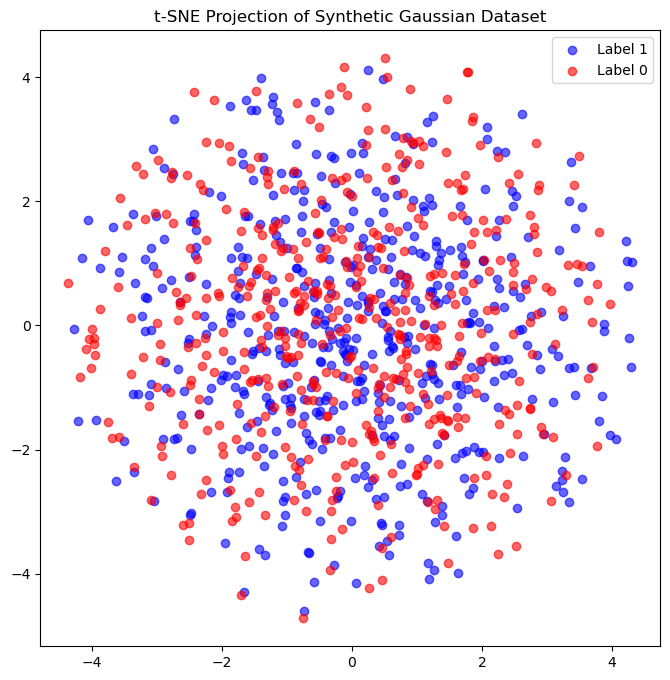

In [70]:
X, y = synthetic_dataset.X.numpy(), synthetic_dataset.y.numpy()

# t-SNE plot of the generated dataset
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)


plt.figure(figsize=(8,8))
plt.scatter(X_tsne[y == 1, 0],X_tsne[y == 1, 1], color='blue', label='Label 1', alpha=0.6)
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], color='red', label='Label 0', alpha=0.6)
plt.title('t-SNE Projection of Synthetic Gaussian Dataset')
plt.legend()
plt.show()

In [71]:
# Datasets and DataLoader
train_dataset, test_dataset = torch.utils.data.random_split(synthetic_dataset, [800, 200])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [72]:
# Experiment on MNIST dataset (Optional)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
MNIST_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
MNIST_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

MNIST_train_loader = torch.utils.data.DataLoader(MNIST_train_data, batch_size=64, shuffle=True)
MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_data, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [01:06<00:00, 148kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 111kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:13<00:00, 121kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.06MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [73]:
## Generating synthetic data

class OrthogonalDataset(Dataset):
    """Basic class for the Orthogonal Dataset as described in "Implicit Bias of Gradient Descent for Two-layer ReLUand Leaky ReLU Networks on Nearly-orthogonal Data" (2023).
    """
    def __init__(self, n:int=1000, d:int=40) -> None:
        """Initialising a Orthogonal Dataset object.mro

        Args:
            n (int, optional): Number of items in the dataste. Defaults to 1000.
            d (int, optional):Dimesion of the feature space. Defaults to 40.
        """
        super(OrthogonalDataset, self).__init__()

        # Initializing values
        self.n = n
        self.d = d

        # Initializing dataset and target vectors
        self.X = np.eye(d)[np.random.choice(d,n)] # Random one-hot vectors
        self.y = np.random.choice([0, 1], size=n) # Random Rademacher variable

        self.X = torch.tensor(self.X, dtype=float)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self) -> int:
        """Length of the dataset (needed for the PyTorch Module class)

        Returns:
            int: length of the dataset.
        """
        return self.n
    
    def __getitem__(self, index:int) -> tuple[torch.Tensor, int]:
        """Return an item of the dataset (needed for the PyTorch Module class).

        Args:
            index (int): Index of the item.

        Returns:
            tuple[torch.Tensor, int]: Item of the dataset at the designated index.
        """
        return self.X[index], self.y[index]

In [74]:
# Datasets and DataLoader
orthogonal_train_dataset = OrthogonalDataset()

# Create data loaders
orthogonal_train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

## Model


In [75]:
class MLP(nn.Module):
    """Basic class for a two-layer MLP neural net with leaky ReLU activation function as described in "Implicit Bias of Gradient Descent for Two-layer ReLUand Leaky ReLU Networks on Nearly-orthogonal Data" (2023).
    """
    def __init__(self, input_size:int=28*28, hidden_size:int=100, output_size:int=2, weight_variance:float=1e-6, leaky_relu_slope:float=0) -> None:
        """Initialize the MLP model.

        Args:
            input_size (int, optional): Input size of the feature vector. Defaults to 28*28.
            hidden_size (int, optional): Hidden size of the middle layer. Defaults to 100.
            output_size (int, optional):Output size of the model. Defaults to 2.
            weight_variance (float, optional): Weight variance for normal initialization of the first layer. Defaults to 1e-6.
            leaky_relu_slope (float, optional): Slope of the leaky ReLU activation function. Defaults to 0.
        """
        super(MLP, self).__init__()

        # Initializing values
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_variance = weight_variance
        self.leaky_relu_slope = leaky_relu_slope 

        # Creating the layers of the model
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(leaky_relu_slope),
            nn.Linear(hidden_size, output_size)
        )

        # Initializing the first layer weight and bias
        init.normal_(self.layers[0].weight, mean=.0, std=weight_variance**.5)
        init.constant_(self.layers[0].bias, 0)

        # Initializing second layer and bias
        init.constant_(self.layers[2].weight, 1/hidden_size)
        init.constant_(self.layers[2].bias, 0)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.

        Args:
            x (torch.Tensor): Input data vector.

        Returns:
            torch.Tensor: Logit output of the model.
        """
        x = x.view(-1, self.input_size)
        out = self.layers(x)
        return out
    
    def stable_rank(self) -> float:
        """Method to calculate the stable rank of the First layer matrix.

        Returns:
            float: Stable rank of the first layer matrix.
        """
        with torch.no_grad():
            first_layer_weights = self.layers[0].weight.cpu().detach().numpy()
            squared_singular_values = np.square(np.linalg.svd(first_layer_weights, compute_uv=False))
            return np.sum(squared_singular_values) / np.max(squared_singular_values)
        
    def neuron_l2_norm(self) -> list[torch.Tensor]:
        """Method to calculate the l2 norm of all neurons in the first layer.

        Returns:
            list[torch.Tensor]: l2 norm of all neurons in the first layer.
        """
        with torch.no_grad():
            return self.layers[0].weight.norm(dim=1)
    

## Training functions


In [76]:
def train(model:nn.Module, train_loader:DataLoader, criterion:nn.Module, optimizer:nn.Module, device:torch.device) -> None:
    """Basic training function for  a given neural net on a training dataset.

    Args:
        model (nn.Module): Model to train
        train_loader (DataLoader): DataLoader object containing the training dataset.
        criterion (nn.Module): Loss function.
        optimizer (nn.Module): Optimizer module.
        device (torch.device): device used for training.
    """

    model.train()

    for _, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model:nn.Module, test_loader:DataLoader, criterion:nn.Module, device:torch.device) -> tuple[float, float]:
    """Evaluate a given neural net on a test dataset and computes loss function and accuracy in the case of binary classification problems.

    Args:
        model (nn.Module): Model to evaluate.
        test_loader (DataLoader): Test Dataset for evaluation.
        criterion (nn.Module): Loss function.
        device (torch.device): Device used for computations.

    Returns:
        tuple[float, float]: mean loss on the test set, accuracy on the test set.
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [77]:
def main_loop(train_loader:DataLoader, test_loader:DataLoader, criterion:nn.Module, device:torch.device, n_epochs:int=10, hidden_size:int=100, output_size:int=2, leaky_relu_slope:float=0, verbose:str=False) -> tuple[list[float], list[list[float]], list[float], list[float]]:
    """Main loop for training, evaluating and computing all useful metrics.

    Args:
        train_loader (DataLoader): Train DataLoader.
        test_loader (DataLoader): Test DataLoader.
        criterion (nn.Module): loss metric.
        device (torch.device): Device use for training
        n_epochs (int, optional): Number of training epochs. Defaults to 10.
        hidden_size (int, optional): Hidden size of the neural net model. Defaults to 100.
        output_size (int, optional): Output size of the neural net model. Defaults to 2.
        leaky_relu_slope (float, optional): Leaky relu slope of the neural net model. Defaults to 0.
        verbose (str, optional):Print test loss and accuracy during training. Defaults to False.

    Returns:
        tuple[list[float], list[list[float]], list[float], list[float]]: Compute lists of various metrics (stable ranks, l2 norm of neurons, test losses, test accuracies) during training.
    """

    model = MLP(hidden_size=hidden_size, output_size=output_size, leaky_relu_slope=leaky_relu_slope).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0)

    rank_records = [model.stable_rank()]
    l2_norm_records = []
    test_loss_records = []
    test_accuracy_records = []


    test_loss, accuracy = evaluate(model, train_loader, criterion, device)
    test_loss_records.append(test_loss)
    test_accuracy_records.append(accuracy)
    
    for epoch in range(1, n_epochs+1):
        train(model, train_loader, criterion, optimizer, device)

        rank_records.append(model.stable_rank())
        l2_norm_records.append(model.neuron_l2_norm())

        test_loss, accuracy = evaluate(model, test_loader, criterion, device)

        test_loss_records.append(test_loss)
        test_accuracy_records.append(accuracy)

        if verbose:
            print(f"Epoch {epoch} : Test loss :{test_loss}, Test accuracy : {accuracy}")

    return rank_records, l2_norm_records, test_loss_records, test_accuracy_records

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0) # Momentum=0 to ensure Gradient descent

criterion = nn.CrossEntropyLoss()

n_epochs = 30


rank_records, l2_norm_records, test_loss_records, test_accuracy_records = main_loop(train_loader, train_loader, criterion, device, n_epochs, leaky_relu_slope=0.1, verbose=True)

Epoch 1 : Test loss :0.011253428980708122, Test accuracy : 51.875
Epoch 2 : Test loss :0.011251868233084678, Test accuracy : 51.875
Epoch 3 : Test loss :0.011248499378561974, Test accuracy : 51.875
Epoch 4 : Test loss :0.011242293491959572, Test accuracy : 51.875
Epoch 5 : Test loss :0.011215851828455924, Test accuracy : 51.875
Epoch 6 : Test loss :0.01114659771323204, Test accuracy : 51.875
Epoch 7 : Test loss :0.010982775837182998, Test accuracy : 52.625
Epoch 8 : Test loss :0.01054168239235878, Test accuracy : 79.375
Epoch 9 : Test loss :0.00955984927713871, Test accuracy : 89.25
Epoch 10 : Test loss :0.007848228923976422, Test accuracy : 91.25
Epoch 11 : Test loss :0.006083484776318073, Test accuracy : 94.0
Epoch 12 : Test loss :0.004403928630053997, Test accuracy : 96.75
Epoch 13 : Test loss :0.0032311572507023813, Test accuracy : 97.5
Epoch 14 : Test loss :0.0023904075007885692, Test accuracy : 98.375
Epoch 15 : Test loss :0.0017854776326566935, Test accuracy : 98.75
Epoch 16 : T

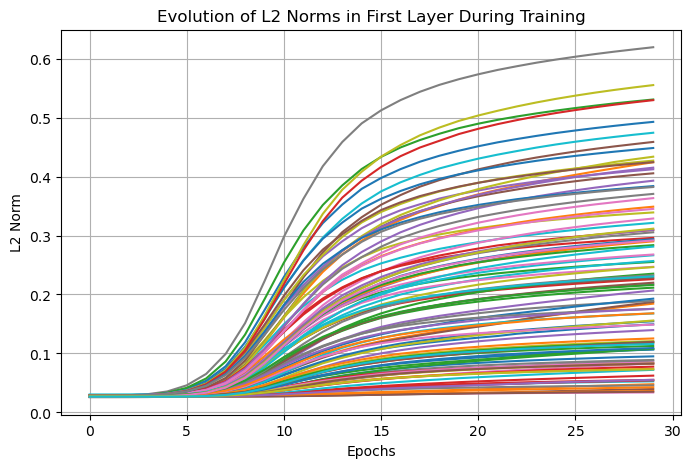

In [79]:
l2_norms_over_time = list(zip(*l2_norm_records))

plt.figure(figsize=(8, 5))
for neuron_idx, neuron_norms in enumerate(l2_norms_over_time):
    plt.plot(neuron_norms)

plt.xlabel("Epochs")
plt.ylabel("L2 Norm")
plt.title("Evolution of L2 Norms in First Layer During Training")
plt.grid(True)
plt.show()

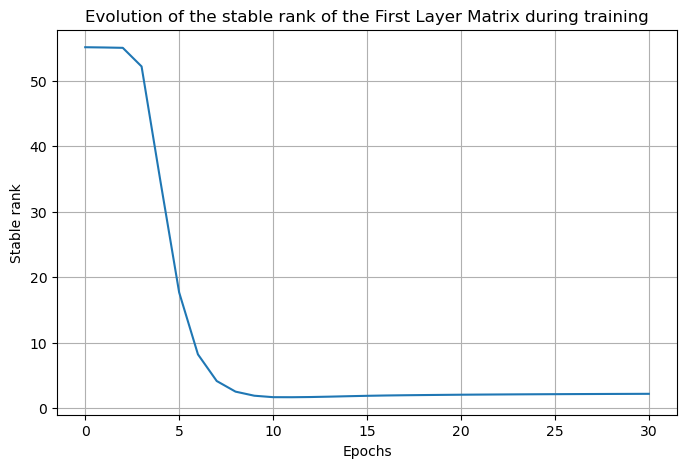

In [80]:
plt.figure(figsize=(8, 5))
plt.plot(rank_records)

plt.xlabel("Epochs")
plt.ylabel("Stable rank")
plt.title("Evolution of the stable rank of the First Layer Matrix during training")
plt.grid(True)
plt.show()

## Multiple experiments


In [81]:
all_rank_records = {}
all_l2_norm_records = {}
all_test_loss_records = {}
all_test_accuracy_records = {}

leaky_slopes = [0, 0.1, 0.5, 1]
n_runs = 5

for slope in leaky_slopes:
    all_rank_records[slope] = []
    all_l2_norm_records[slope] = []
    all_test_loss_records[slope] = []
    all_test_accuracy_records[slope] = []
    for run in range(n_runs):
        print(f"Training with slope {slope} - Run {run+1}")
        rank_records, l2_norm_records, test_loss_records, test_accuracy_records = main_loop(train_loader, train_loader, criterion, device, n_epochs=30, hidden_size=100, leaky_relu_slope=slope)
        all_rank_records[slope].append(rank_records)
        all_l2_norm_records[slope].append(l2_norm_records)
        all_test_loss_records[slope].append(test_loss_records)
        all_test_accuracy_records[slope].append(test_accuracy_records)

Training with slope 0 - Run 1
Training with slope 0 - Run 2
Training with slope 0 - Run 3
Training with slope 0 - Run 4
Training with slope 0 - Run 5
Training with slope 0.1 - Run 1
Training with slope 0.1 - Run 2
Training with slope 0.1 - Run 3
Training with slope 0.1 - Run 4
Training with slope 0.1 - Run 5
Training with slope 0.5 - Run 1
Training with slope 0.5 - Run 2
Training with slope 0.5 - Run 3
Training with slope 0.5 - Run 4
Training with slope 0.5 - Run 5
Training with slope 1 - Run 1
Training with slope 1 - Run 2
Training with slope 1 - Run 3
Training with slope 1 - Run 4
Training with slope 1 - Run 5


In [82]:
num_epochs = len(all_rank_records[leaky_slopes[0]][0])

rank_means = {ls: np.zeros(num_epochs) for ls in leaky_slopes}
rank_stds = {ls: np.zeros(num_epochs) for ls in leaky_slopes}
loss_means = {ls: np.zeros(num_epochs) for ls in leaky_slopes}
loss_stds = {ls: np.zeros(num_epochs) for ls in leaky_slopes}
acc_means = {ls: np.zeros(num_epochs) for ls in leaky_slopes}
acc_stds = {ls: np.zeros(num_epochs) for ls in leaky_slopes}
mean_neuron_norm_means = {ls: np.zeros(num_epochs) for ls in leaky_slopes}
mean_neuron_norm_stds = {ls: np.zeros(num_epochs) for ls in leaky_slopes}

for slope in leaky_slopes:
    rank_matrix = np.array(all_rank_records[slope])
    loss_matrix = np.array(all_test_loss_records[slope])
    acc_matrix = np.array(all_test_accuracy_records[slope])
    mean_neuron_norm_matrix = np.array(np.mean(all_l2_norm_records[0], axis=2))
    mean_neuron_norm_matrix = np.array(np.mean(all_l2_norm_records[0], axis=2))

    rank_means[slope] = np.mean(rank_matrix, axis=0)
    rank_stds[slope] = np.std(rank_matrix, axis=0)

    loss_means[slope] = np.mean(loss_matrix, axis=0)
    loss_stds[slope] = np.std(loss_matrix, axis=0)

    acc_means[slope] = np.mean(acc_matrix, axis=0)
    acc_stds[slope] = np.std(acc_matrix, axis=0)

    mean_neuron_norm_means[slope] = np.mean(mean_neuron_norm_matrix, axis=0)
    mean_neuron_norm_stds[slope] = np.std(mean_neuron_norm_matrix, axis=0)

## Visualizing results


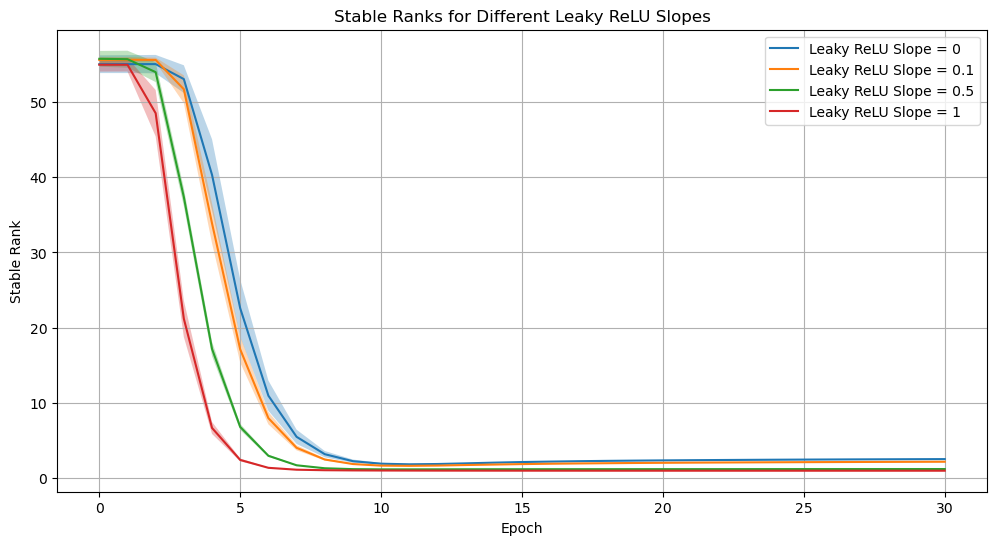

In [83]:
# Plot means and shaded regions of Stable rank
fig = plt.figure(figsize=(12,6))

for leaky_slope in leaky_slopes:
    plt.plot(rank_means[leaky_slope], label=f'Leaky ReLU Slope = {leaky_slope}')
    plt.fill_between(range(num_epochs), rank_means[leaky_slope] - rank_stds[leaky_slope], rank_means[leaky_slope] + rank_stds[leaky_slope], alpha=0.3)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Stable Rank')
plt.title('Stable Ranks for Different Leaky ReLU Slopes')
plt.grid()
plt.show()

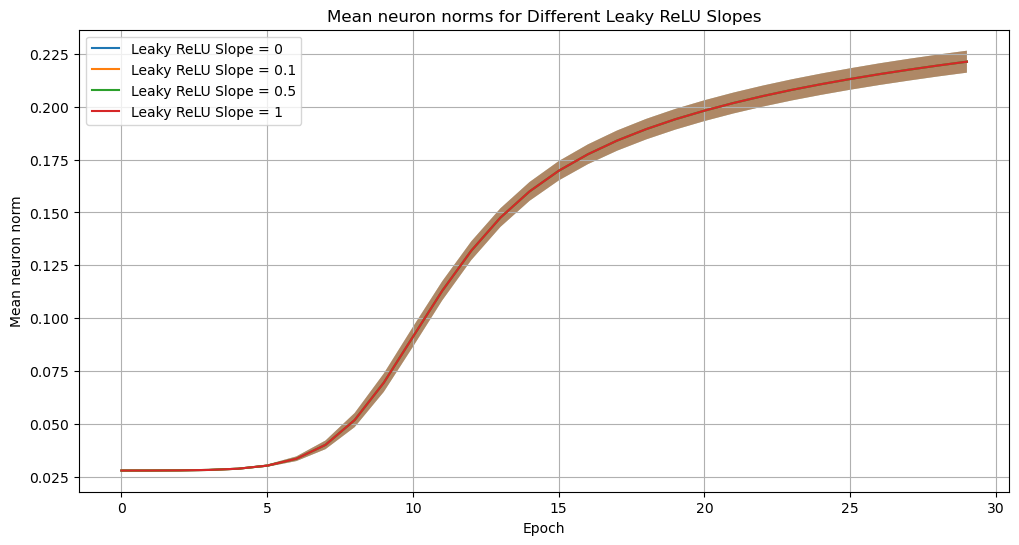

In [84]:
# Plot means and shaded regions of mean neuron norm
fig = plt.figure(figsize=(12,6))

for leaky_slope in leaky_slopes:
    plt.plot(mean_neuron_norm_means[leaky_slope], label=f'Leaky ReLU Slope = {leaky_slope}')
    plt.fill_between(range(num_epochs-1), mean_neuron_norm_means[leaky_slope] - mean_neuron_norm_stds[leaky_slope], mean_neuron_norm_means[leaky_slope] + mean_neuron_norm_stds[leaky_slope], alpha=0.3)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean neuron norm')
plt.title('Mean neuron norms for Different Leaky ReLU Slopes')
plt.grid()
plt.show()

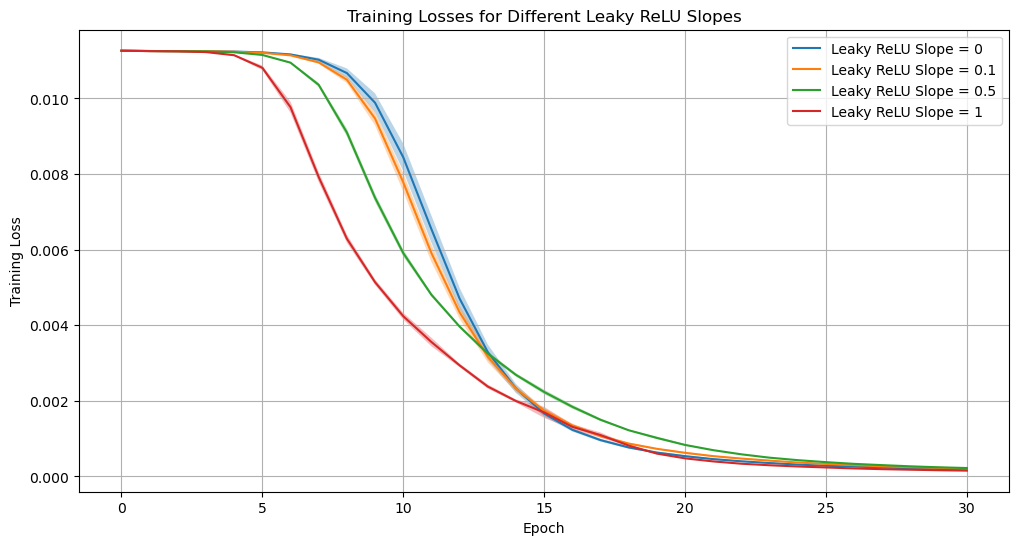

In [85]:
# Plot means and shaded regions of Train loss
fig = plt.figure(figsize=(12,6))

for leaky_slope in leaky_slopes:
    plt.plot(loss_means[leaky_slope], label=f'Leaky ReLU Slope = {leaky_slope}')
    plt.fill_between(range(num_epochs), loss_means[leaky_slope] - loss_stds[leaky_slope], loss_means[leaky_slope] + loss_stds[leaky_slope], alpha=0.3)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Losses for Different Leaky ReLU Slopes')
plt.grid()
plt.show()

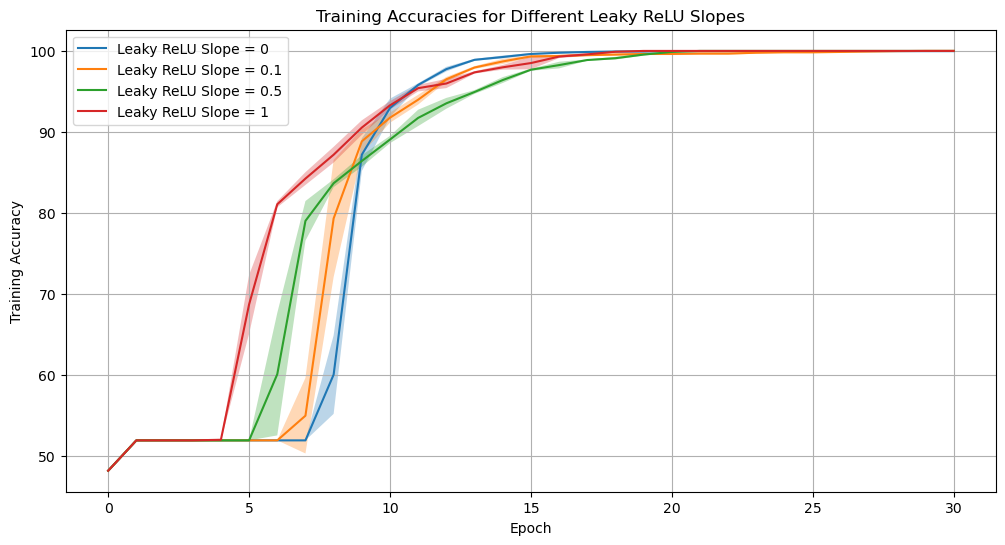

In [86]:
# Plot means and shaded regions of Train loss
fig = plt.figure(figsize=(12,6))

for leaky_slope in leaky_slopes:
    plt.plot(acc_means[leaky_slope], label=f'Leaky ReLU Slope = {leaky_slope}')
    plt.fill_between(range(num_epochs), acc_means[leaky_slope] - acc_stds[leaky_slope], acc_means[leaky_slope] + acc_stds[leaky_slope], alpha=0.3)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracies for Different Leaky ReLU Slopes')
plt.grid()
plt.show()